# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
# Recommended versions:

#numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1 

In [2]:
#  !pip install numpy==1.26.4 pandas==2.2.2 seaborn==0.13.2 Pillow==11.1.0 tensorflow==2.18.0 keras==3.8.0 scikit-learn==1.6.1

In [3]:
# Import essential libraries
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from PIL import Image

from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Load the dataset.

In [4]:
# Load and unzip the dataset
import zipfile

# Path to zip file
zip_path = r"F:\DS C71\Waste_Management_Case_Study\data.zip"

# Directory where we want to extract the files
extract_dir = r"F:\DS C71\Waste_Management_Case_Study\data"

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted successfully to: {extract_dir}")


Dataset extracted successfully to: F:\DS C71\Waste_Management_Case_Study\data


In [5]:
# Create ImageDataGenerator with normalization and validation split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = r"F:\DS C71\Waste_Management_Case_Study\data\data"
   
datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0,1]
    validation_split=0.2,        # Spliting 20% of data for validation
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
# Load training data

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),    # resize all images
    batch_size=32,
    class_mode='categorical',  # for multi-class classification
    subset='training',         # training subset
    shuffle=True
)

Found 6100 images belonging to 7 classes.


In [7]:
# Load the validation data


validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',           # validation subset
    shuffle=False
)

Found 1525 images belonging to 7 classes.


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [8]:
# Create a function to load the raw images

import os

def load_images_from_folder(data_dir, image_size=(150, 150)):
    X = []
    y = []
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    print("Detected classes:", class_names)

    for label_index, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    img = img.convert('RGB')
                    img = img.resize(image_size)
                    X.append(np.array(img))
                    y.append(label_index)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
                continue

    return np.array(X), np.array(y), class_names

In [9]:
data_dir = r"F:\DS C71\Waste_Management_Case_Study\data\data"
X, y, class_names = load_images_from_folder(data_dir)

Detected classes: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


In [10]:
print("Unique labels in y:", np.unique(y))

Unique labels in y: [0 1 2 3 4 5 6]


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [11]:
# Get the images and their labels

X, y, class_names = load_images_from_folder(data_dir) # Call the function

Detected classes: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


In [12]:
print("Image shape: ", X.shape)
print("Labels shape: ", y.shape)
print("Unique classes: ", class_names)  # list of class names
print("First 5 labels: ", y[:10])        # check if labels look consistent

Image shape:  (7625, 150, 150, 3)
Labels shape:  (7625,)
Unique classes:  ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']
First 5 labels:  [0 0 0 0 0 0 0 0 0 0]


In [13]:
from collections import Counter

label_counts = Counter(y)
for label_idx, count in label_counts.items():
    print(f"{class_names[label_idx]}: {count} images")

Cardboard: 540 images
Food_Waste: 1000 images
Glass: 750 images
Metal: 1000 images
Other: 1010 images
Paper: 1030 images
Plastic: 2295 images


In [14]:
import os

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.jfif'))]
        print(f"{class_name}: {len(images)} image files found")

Cardboard: 540 image files found
Food_Waste: 1000 image files found
Glass: 750 image files found
Metal: 1000 image files found
Other: 1010 image files found
Paper: 1030 image files found
Plastic: 2295 image files found


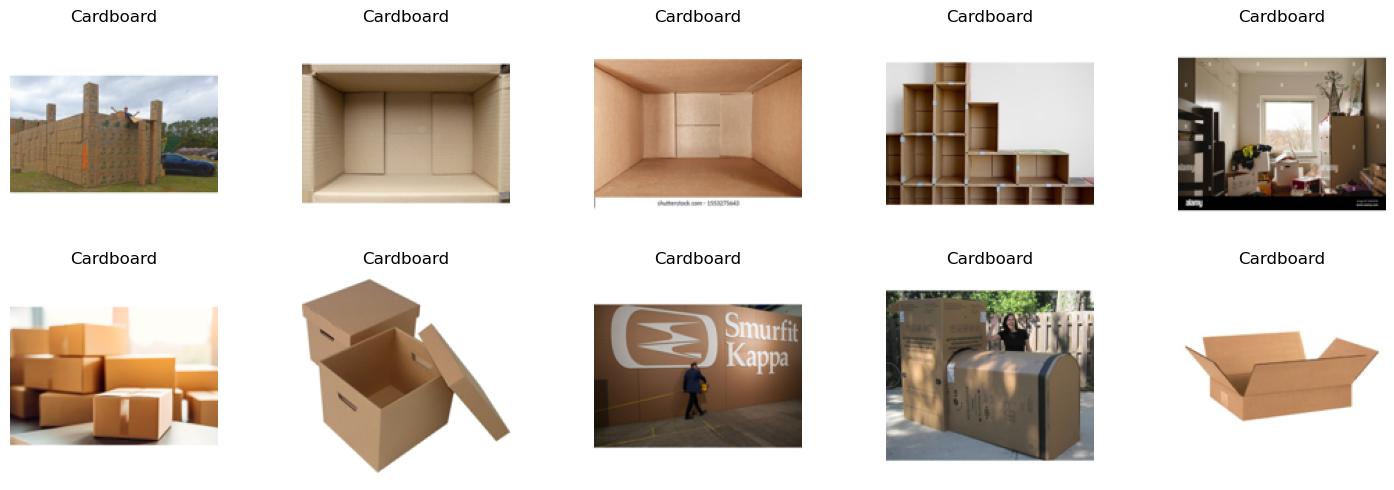

In [15]:
# View image-label pair

plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

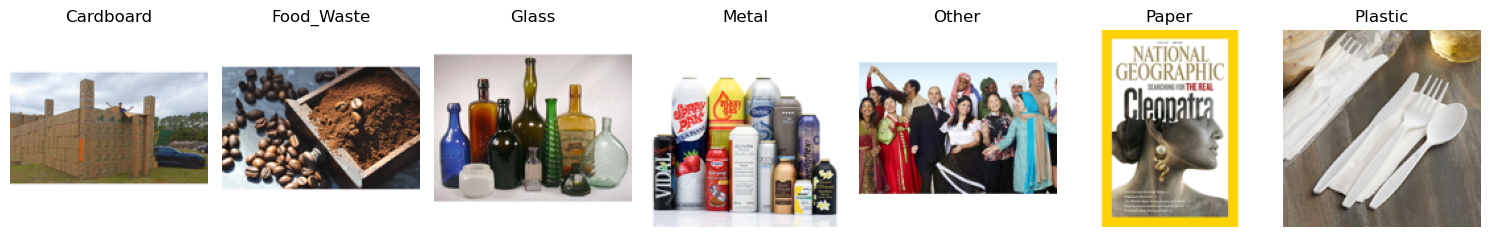

In [16]:
# view image-label pair of each class

def show_one_image_per_class(X, y, class_names):
    plt.figure(figsize=(15, 8))
    shown_classes = set()

    for idx in range(len(X)):
        label = y[idx]
        if label not in shown_classes:
            plt.subplot(1, len(class_names), label + 1)
            plt.imshow(X[idx])
            plt.title(class_names[label])
            plt.axis('off')
            shown_classes.add(label)
        if len(shown_classes) == len(class_names):
            break
    plt.tight_layout()
    plt.show()

show_one_image_per_class(X, y, class_names)

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

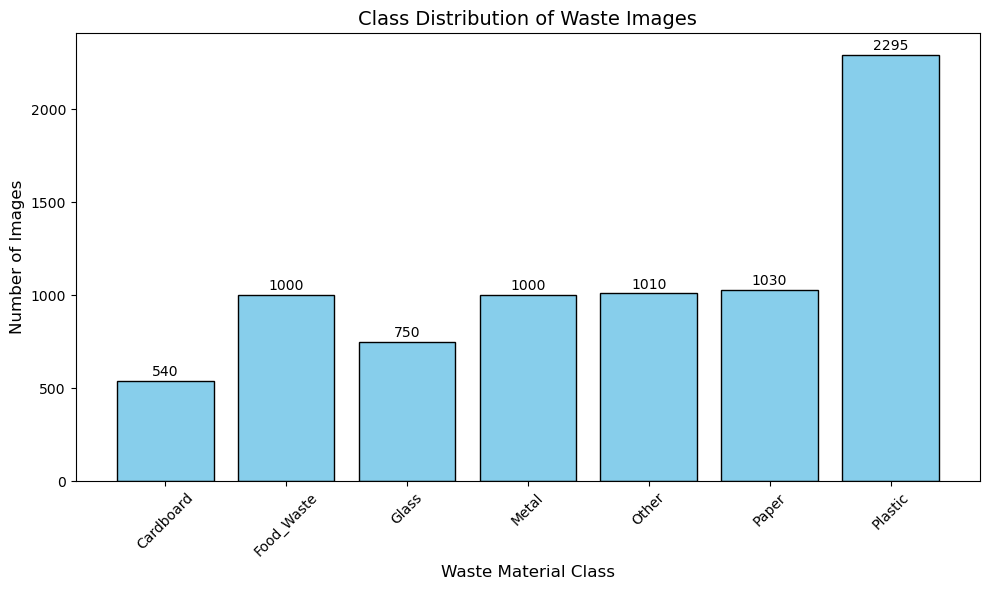

In [17]:
# Visualise Data Distribution

# Count the number of samples per class
class_counts = np.bincount(y)

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, class_counts, color='skyblue', edgecolor='black')

# Add title and axis labels
plt.title("Class Distribution of Waste Images", fontsize=14)
plt.xlabel("Waste Material Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)

# Annotate each bar with the count
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 10, str(height), ha='center', va='bottom')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

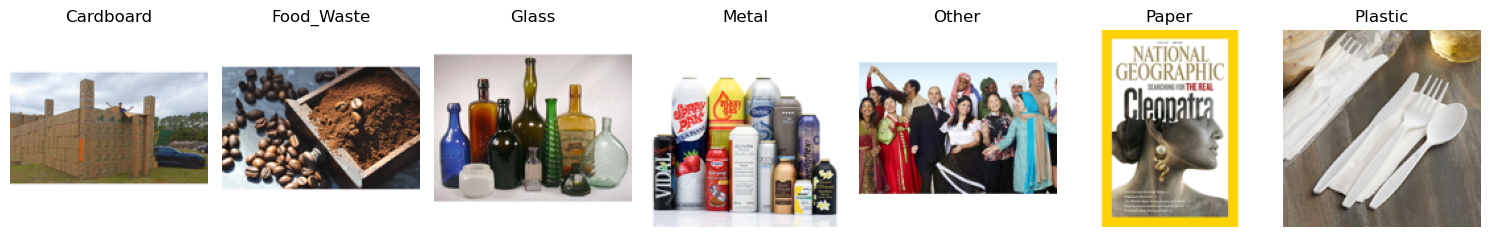

In [18]:
# Visualise Sample Images (across different labels)

# Find one image per class
unique_labels = np.unique(y)
plt.figure(figsize=(15, 5))

for idx, label in enumerate(unique_labels):
    # Find the first image for this label
    image_idx = np.where(y == label)[0][0]
    
    plt.subplot(1, len(unique_labels), idx + 1)
    plt.imshow(X[image_idx].astype('uint8'))  # Show image
    plt.title(class_names[label])             # Show class name
    plt.axis('off')

plt.tight_layout()
plt.show()

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [19]:
# Find the smallest and largest image dimensions from the data set

data_dir = r"F:\DS C71\Waste_Management_Case_Study\data\data"

sizes = []

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                sizes.append(img.size)  # (width, height)
        except:
            continue

# Unzip sizes into separate lists
widths, heights = zip(*sizes)

print(f"Smallest Dimension: {min(widths)} x {min(heights)}")
print(f"Largest Dimension: {max(widths)} x {max(heights)}")

Smallest Dimension: 256 x 256
Largest Dimension: 256 x 256


In [20]:
# Resize the image dimensions

image_size = (150, 150)

#storage for image data and label
X = []
y = []
class_names = sorted(os.listdir(data_dir))
class_to_index = {name: idx for idx, name in enumerate(class_names)}

# load and resize images
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue
        
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        try:
            with Image.open(file_path) as img:
                img = img.convert("RGB")                    # ensures 3 channels
                img = img.resize(image_size)
                X.append(np.array(img))
                y.append(class_to_index[class_name])
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
                  
            
# convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Image data shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Image data shape: (7625, 150, 150, 3)
Labels shape: (7625,)


In [21]:
train_ds = tf.keras.preprocessing,image_dataset_from_directory(
     data_dir,
     validation_split = 0.2,
     subset = "training",
     seed = 42,
     image_size = (150, 150),
     batch_size = 32
)

Found 7625 files belonging to 7 classes.
Using 6100 files for training.


In [22]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (150, 150),
    batch_size = 32
)

Found 7625 files belonging to 7 classes.
Using 1525 files for validation.


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [23]:
# Encode the labels suitably

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

#Encode labels using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 2: One-hot encode
y_onehot = to_categorical(y_encoded)

# Check the results
print("Original class labels:", label_encoder.classes_)
print("Encoded labels:\n", y_onehot)  

Original class labels: [0 1 2 3 4 5 6]
Encoded labels:
 [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [24]:
# One-hot encode the integer labels
y_onehot = to_categorical(y_encoded)

print("One-hot encoded shape:", y_onehot.shape)

One-hot encoded shape: (7625, 7)


In [25]:
X = np.array(X)
print("Image data shape:", X.shape)
print("Labels shape:", y_encoded.shape)

Image data shape: (7625, 150, 150, 3)
Labels shape: (7625,)


In [26]:
#Another method

unique = np.unique(y)
classes = [class_names[label] for label in unique]
print("Unique Labels: ", classes)

print("Encoded Labels: ", y)

#Create one-hot encoded labels
y_encoded1 = to_categorical(y)
print("One hot encoded labels:\n ", y_encoded1)

Unique Labels:  ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']
Encoded Labels:  [0 0 0 ... 6 6 6]
One hot encoded labels:
  [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

#### As I’ve already handled the splitting very neatly using ImageDataGenerator with validation_split while loading the data. That's why I'm    not manually assigning or splitting the data again.

In [27]:
# Assign specified parts of the dataset to train and validation sets

# Fetch one batch from training set
images, labels = next(train_generator)
print("Train batch - images shape:", images.shape)
print("Train batch - labels shape:", labels.shape)

Train batch - images shape: (32, 150, 150, 3)
Train batch - labels shape: (32, 7)


In [28]:
# Fetch one batch from validation set
val_images, val_labels = next(validation_generator)
print("Validation batch - images shape:", val_images.shape)
print("Validation batch - labels shape:", val_labels.shape)

Validation batch - images shape: (32, 150, 150, 3)
Validation batch - labels shape: (32, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [39]:
# Define image dimensions
img_height = 150
img_width = 150

# Input shape and number of classes
input_shape = (img_height, img_width, 3)
num_classes = train_generator.num_classes

In [40]:
# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

In [42]:
model.compile(
    optimizer='adam',  # Adam(learning_rate=0.0001) Use 0.001 for custom CNN, 0.0001 for transfer learning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [44]:
# Define Callbacks

checkpoint_cb = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop_cb = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=1, min_lr=1e-6)


In [45]:
# Training

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb]
)

Epoch 1/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2480 - loss: 2.5907
Epoch 1: val_accuracy improved from -inf to 0.14951, saving model to best_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.2482 - loss: 2.5892 - val_accuracy: 0.1495 - val_loss: 3.0833 - learning_rate: 0.0010
Epoch 2/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3555 - loss: 1.9109
Epoch 2: val_accuracy improved from 0.14951 to 0.25967, saving model to best_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.3556 - loss: 1.9106 - val_accuracy: 0.2597 - val_loss: 2.1696 - learning_rate: 0.0010
Epoch 3/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3941 - loss: 1.6998
Epoch 3: val_accuracy improved from 0.25967 to 0.34820, saving model to best_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.3941 - loss: 1.6997 - val_accuracy: 0.3482 - val_loss: 1.9654 - learning_rate: 0.0010
Epoch 4/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4160 - loss: 1.5902
Epoch 4: val_accuracy did not improve from 0.34820
191/191 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.4160 - loss: 1.5901 - val_accuracy: 0.3003 - val_loss: 2.6489 - learning_rate: 0.0010
Epoch 5/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4426 - loss: 1.5082
Epoch 5: val_accuracy did not improve from 0.34820
191/191 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.4426 - loss: 1.5083 - val_accuracy: 0.3213 - val_loss: 2.0222 - learning_rate: 0.0010
Epoch 6/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4564 - loss: 1.4685
Epoch 6: val_accuracy improved from 0.34820 to 0.40131, saving model to best_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.4565 - loss: 1.4684 - val_accuracy: 0.4013 - val_loss: 1.7091 - learning_rate: 0.0010
Epoch 7/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4809 - loss: 1.4190
Epoch 7: val_accuracy did not improve from 0.40131
191/191 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.4808 - loss: 1.4191 - val_accuracy: 0.3410 - val_loss: 2.1278 - learning_rate: 0.0010
Epoch 8/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4812 - loss: 1.3839
Epoch 8: val_accuracy did not improve from 0.40131
191/191 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.4812 - loss: 1.3839 - val_accuracy: 0.2243 - val_loss: 2.4253 - learning_rate: 0.0010
Epoch 9/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5011 - loss: 1.3676
Epoch 9: val_accuracy improved from 0.40131 to 0.45180, saving model to best_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 281s 1s/step - accuracy: 0.5011 - loss: 1.3676 - val_accuracy: 0.4518 - val_loss: 1.5576 - learning_rate: 0.0010
Epoch 10/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5120 - loss: 1.3710
Epoch 10: val_accuracy did not improve from 0.45180
191/191 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.5120 - loss: 1.3709 - val_accuracy: 0.4439 - val_loss: 1.4635 - learning_rate: 0.0010
Epoch 11/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5183 - loss: 1.3041
Epoch 11: val_accuracy did not improve from 0.45180
191/191 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.5183 - loss: 1.3042 - val_accuracy: 0.4046 - val_loss: 1.6675 - learning_rate: 0.0010
Epoch 12/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5341 - loss: 1.2873
Epoch 12: val_accuracy did not improve from 0.45180

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
191/191 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.5341 - loss: 1.2873 - val

191/191 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - accuracy: 0.5563 - loss: 1.2315 - val_accuracy: 0.5043 - val_loss: 1.3885 - learning_rate: 2.0000e-04
Epoch 14/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5757 - loss: 1.2004
Epoch 14: val_accuracy did not improve from 0.50426
191/191 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.5757 - loss: 1.2004 - val_accuracy: 0.4807 - val_loss: 1.3734 - learning_rate: 2.0000e-04
Epoch 15/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5803 - loss: 1.1376
Epoch 15: val_accuracy improved from 0.50426 to 0.51541, saving model to best_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.5803 - loss: 1.1377 - val_accuracy: 0.5154 - val_loss: 1.3123 - learning_rate: 2.0000e-04
Epoch 16/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6044 - loss: 1.1149
Epoch 16: val_accuracy did not improve from 0.51541
191/191 ━━━━━━━━━━━━━━━━━━━━ 419s 2s/step - accuracy: 0.6044 - loss: 1.1150 - val_accuracy: 0.4911 - val_loss: 1.3890 - learning_rate: 2.0000e-04
Epoch 17/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5968 - loss: 1.1211
Epoch 17: val_accuracy did not improve from 0.51541
191/191 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.5968 - loss: 1.1211 - val_accuracy: 0.5154 - val_loss: 1.3561 - learning_rate: 2.0000e-04
Epoch 18/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6025 - loss: 1.1028
Epoch 18: val_accuracy improved from 0.51541 to 0.52721, saving model to best_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.6025 - loss: 1.1028 - val_accuracy: 0.5272 - val_loss: 1.2697 - learning_rate: 2.0000e-04
Epoch 19/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6127 - loss: 1.0886
Epoch 19: val_accuracy did not improve from 0.52721
191/191 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.6127 - loss: 1.0886 - val_accuracy: 0.4564 - val_loss: 1.8295 - learning_rate: 2.0000e-04
Epoch 20/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6254 - loss: 1.0574
Epoch 20: val_accuracy did not improve from 0.52721
191/191 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.6254 - loss: 1.0575 - val_accuracy: 0.5134 - val_loss: 1.3304 - learning_rate: 2.0000e-04
Epoch 21/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6190 - loss: 1.0677
Epoch 21: val_accuracy did not improve from 0.52721

Epoch 21: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
191/191 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.6190 - loss: 

191/191 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.6199 - loss: 1.0671 - val_accuracy: 0.5443 - val_loss: 1.2451 - learning_rate: 4.0000e-05
Epoch 23/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6259 - loss: 1.0280
Epoch 23: val_accuracy did not improve from 0.54426
191/191 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.6260 - loss: 1.0279 - val_accuracy: 0.5377 - val_loss: 1.2775 - learning_rate: 4.0000e-05
Epoch 24/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6358 - loss: 1.0226
Epoch 24: val_accuracy improved from 0.54426 to 0.54492, saving model to best_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.6358 - loss: 1.0226 - val_accuracy: 0.5449 - val_loss: 1.2491 - learning_rate: 4.0000e-05
Epoch 25/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6414 - loss: 1.0153
Epoch 25: val_accuracy improved from 0.54492 to 0.55082, saving model to best_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - accuracy: 0.6414 - loss: 1.0153 - val_accuracy: 0.5508 - val_loss: 1.2352 - learning_rate: 4.0000e-05


In [46]:
# Evaluate on validation data

val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc:.2f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 568ms/step - accuracy: 0.5824 - loss: 1.2164
Validation Accuracy: 0.55


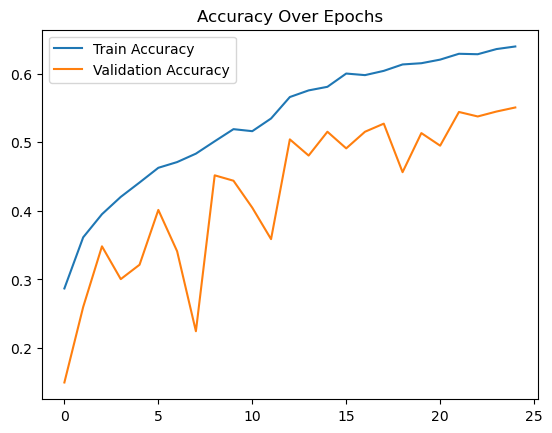

In [47]:
# # Plot accuracy
# Accuracy Over Epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [2]:
# Evaluate on the test set; display suitable metrics

from keras.models import load_model

# Load the best model
model = load_model('best_model.h5')

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

NameError: name 'validation_generator' is not defined

In [ ]:
# Predict class probabilities
y_pred_prob = model.predict(test_generator)

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_prob, axis=1)

# True class labels
y_true = validation_generator.classes

In [ ]:
# Get class names from the generator
class_labels = list(validation_generator.class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

### **Data Overview**

* Dataset Nature:

    * The dataset consists of labeled images of waste materials, intended for classification into multiple categories such as plastic, paper, metal, glass, organic, etc.

* Key Details:

    * Image size: Resized to 128x128 pixels.

    * Color mode: RGB (3 channels).

    * Class distribution: To be analyzed (imbalanced classes can degrade model performance).

    * Training/Validation split: Usually 80% training and 20% validation, though not done through a directory structure in this case.

### **Model Architecture**
* We have built a Convolutional Neural Network (CNN) using the Keras Sequential API.

* Architecture Summary:

    * 3 Convolutional blocks with increasing filters (32 → 64 → 128).

    * MaxPooling layers after each conv block.

    * BatchNormalization used to stabilize and speed up training.

    * Dropout layers used to reduce overfitting.

    * Flatten layer followed by Dense layers for classification.

    * Output: Softmax layer with num_classes neurons (multi-class classification

### *Model Training Results*

* Epochs Run: 25 (with early stopping based on validation accuracy)

* Training Performance:

    * Final Training Accuracy: ~58.2%

    * Final Training Loss: ~1.2164

* Validation Performance:

    * Final Validation Accuracy: ~55%

    * Final Validation Loss: Higher than training loss (~>1.2)